In [1]:
# Visualization of activity difference between a classical neural network and a FGnet
# shows that FGNs are trainable over multiple layers
# shows that FGNs have less linear seperation of space

# this notebook showcases full fgn nets where only the first layer has trainable centers

# you can try various: Network sizes, dropout probs, lambdas in the losses, different 2d data sets

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets
from sklearn.utils import shuffle as shuffle_in_unison


import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device

torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [6]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [7]:
total_num_samples = 2048

# random moons
samples, labels = datasets.make_moons(n_samples=total_num_samples, noise=0.2, shuffle=True)

# random concentric circles
# samples, labels = datasets.make_circles(n_samples=total_num_samples, noise=0.08, factor=0.4, shuffle=True)

# train/test split
ratio=4.0/5.0
split_index = int(len(samples)*ratio)

train_samples, train_labels = samples[:split_index], labels[:split_index]
test_samples, test_labels = samples[split_index:], labels[split_index:]


# add noise?
X1 = np.arange(-10.0, 10.01, 0.5)
X1s, X2s = np.meshgrid(X1,X1)
noise_samples = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))
noise_labels = np.array([np.random.choice([0,1]) for _ in range(len(noise_samples))])


# train_samples = np.concatenate((train_samples ,noise_samples),axis=0)
# train_labels = np.concatenate((train_labels ,noise_labels),axis=0)

# train_samples = noise_samples
# train_labels = noise_labels

num_samples = len(train_samples)

<IPython.core.display.Javascript object>


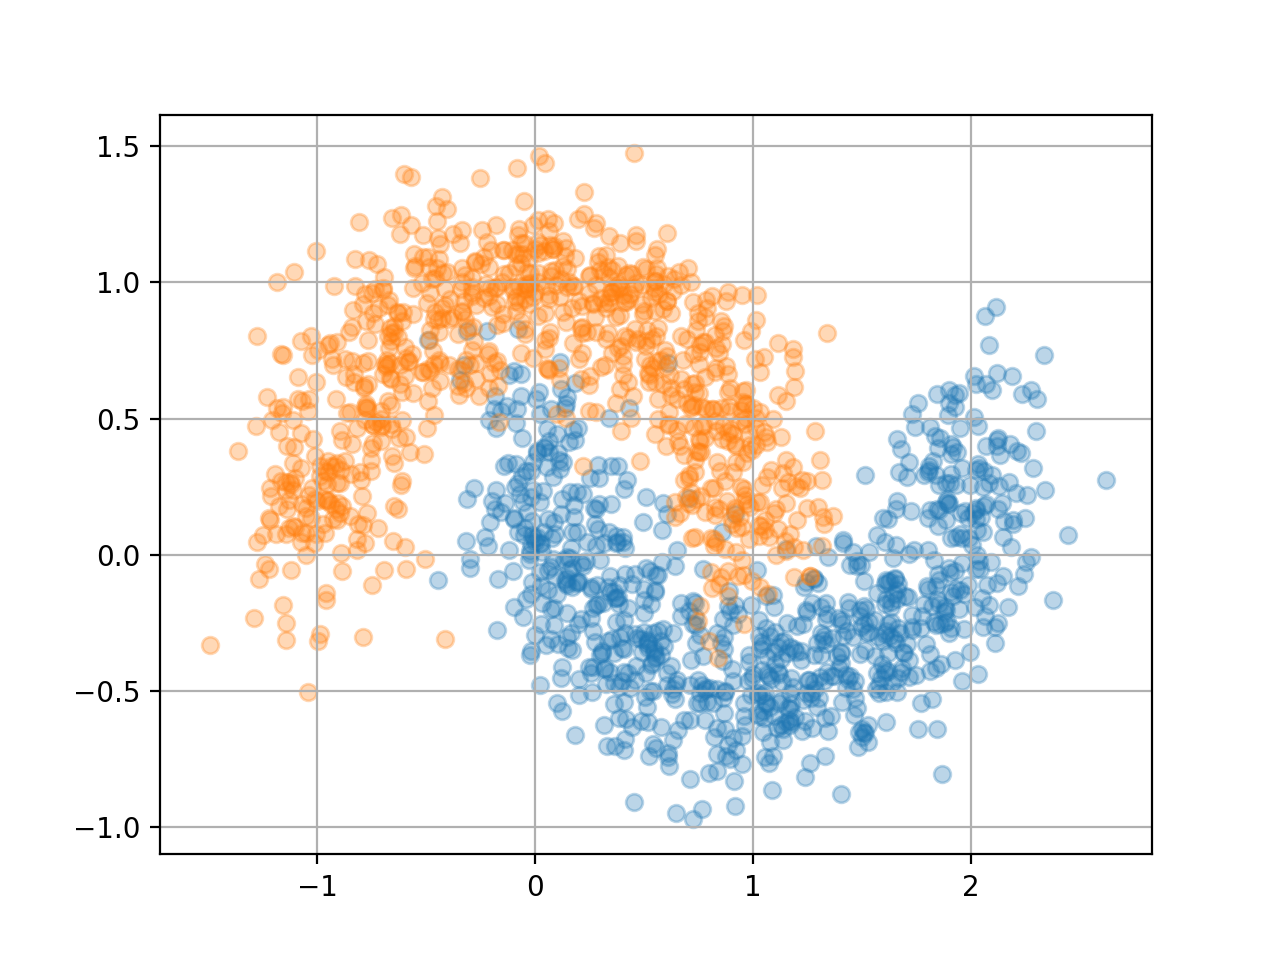

In [8]:
# 2D Check 
samples_x_1 = [x for x,l in zip(train_samples[:,0], train_labels) if l==0]
samples_y_1 = [y for y,l in zip(train_samples[:,1], train_labels) if l==0]

samples_x_2 = [x for x,l in zip(train_samples[:,0], train_labels) if l==1]
samples_y_2 = [y for y,l in zip(train_samples[:,1], train_labels) if l==1]

plt.scatter(samples_x_2, samples_y_2, alpha=0.3)
plt.scatter(samples_x_1, samples_y_1, alpha=0.3)

plt.grid(True)
plt.show()

In [9]:
# convert data to pytorch format 
tensor_train_x = torch.Tensor(train_samples)
tensor_train_y = torch.Tensor(train_labels)

tensor_test_x = torch.Tensor(test_samples)
tensor_test_y = torch.Tensor(test_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_train_x, tensor_train_y) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_test_x,tensor_test_y) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=192, shuffle=True) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data, shuffle=True) # create your dataloader

In [10]:
# networks params
hidden_l_nums = [128]
drop_p = 0.

In [11]:
### PART 3: Hybrid network with just the final layer as FGN, other hidden layers as Linear 

In [12]:
### Loss Functions for the hybrids FGN

# importances of the constraints
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
lmbda_sigs = 100.0*lmbda_l2
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

fgn_cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

lambda for l2 loss 0.0002442002442
lambda for sigs^2 loss 0.02442002442


In [13]:
# Initialize the hyrbid network
print("hidden layers:", hidden_l_nums)
print("drop prob:", drop_p)
noisy_centers = True
print("noisy centers:", noisy_centers)
first_centers_model = fgnl.Feedforward_First_Centers_net(in_feats=2, out_feats=2, hidden_l_nums=hidden_l_nums,
                                     drop_p=drop_p, noisy_centers=noisy_centers).to(device)

hidden layers: [128]
drop prob: 0.0
noisy centers: True
True


In [14]:
# define model params to optimize
first_centers_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, first_centers_model.parameters()),momentum=0.5)

In [15]:
epochs = 10

In [16]:
# train the network for N epochs
print("# epochs:", epochs)
first_centers_train_res = fgnh.train(first_centers_model, my_dataloader, 
                             fgn_cross_ent_loss, first_centers_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

# epochs: 10
Epoch 0 Train set - Average loss: 19.0750, Accuracy: 1195/1638 (73%)
Test set - Average loss: 3.5886, Accuracy: 363/410 (89%)
Epoch 1 Train set - Average loss: 2.8089, Accuracy: 1426/1638 (87%)
Test set - Average loss: 0.5334, Accuracy: 370/410 (90%)
Epoch 2 Train set - Average loss: 1.3806, Accuracy: 1397/1638 (85%)
Test set - Average loss: 0.3285, Accuracy: 387/410 (94%)
Epoch 3 Train set - Average loss: 0.3742, Accuracy: 1546/1638 (94%)
Test set - Average loss: 0.2252, Accuracy: 394/410 (96%)
Epoch 4 Train set - Average loss: 0.2884, Accuracy: 1557/1638 (95%)
Test set - Average loss: 0.2055, Accuracy: 399/410 (97%)
Epoch 5 Train set - Average loss: 0.2365, Accuracy: 1578/1638 (96%)
Test set - Average loss: 0.1880, Accuracy: 402/410 (98%)
Epoch 6 Train set - Average loss: 0.2447, Accuracy: 1575/1638 (96%)
Test set - Average loss: 0.2073, Accuracy: 397/410 (97%)
Epoch 7 Train set - Average loss: 0.2802, Accuracy: 1551/1638 (95%)
Test set - Average loss: 0.1890, Accuracy: 

In [17]:
# test the statibility of the model (these numbers should be same as final lines above)
first_centers_test_res = fgnh.test(first_centers_model, my_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

first_centers_test_res = fgnh.test(first_centers_model, my_test_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.2037, Accuracy: 1594/1638 (97%)
Test set - Average loss: 0.1769, Accuracy: 401/410 (98%)


In [18]:
# scale of the heat maps
X1 = np.arange(-10.0, 10.01, 0.1)
X1s, X2s = np.meshgrid(X1,X1)
heatmap_inputs = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))
print("shape of heatmap", np.shape(heatmap_inputs))
heatmap_inputs = torch.Tensor(heatmap_inputs)
print(type(heatmap_inputs))
# print(heatmap_inputs)

shape of heatmap (40401, 2)
<class 'torch.Tensor'>


In [19]:
# compute predictions for heatmap
first_centers_model.eval()
first_centers_heatmap_preds = first_centers_model(heatmap_inputs.to(device))
first_centers_heatmap_preds = first_centers_heatmap_preds.cpu().detach().numpy()
# apply softmax for probs
first_centers_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in first_centers_heatmap_preds.astype('float128')])

<IPython.core.display.Javascript object>


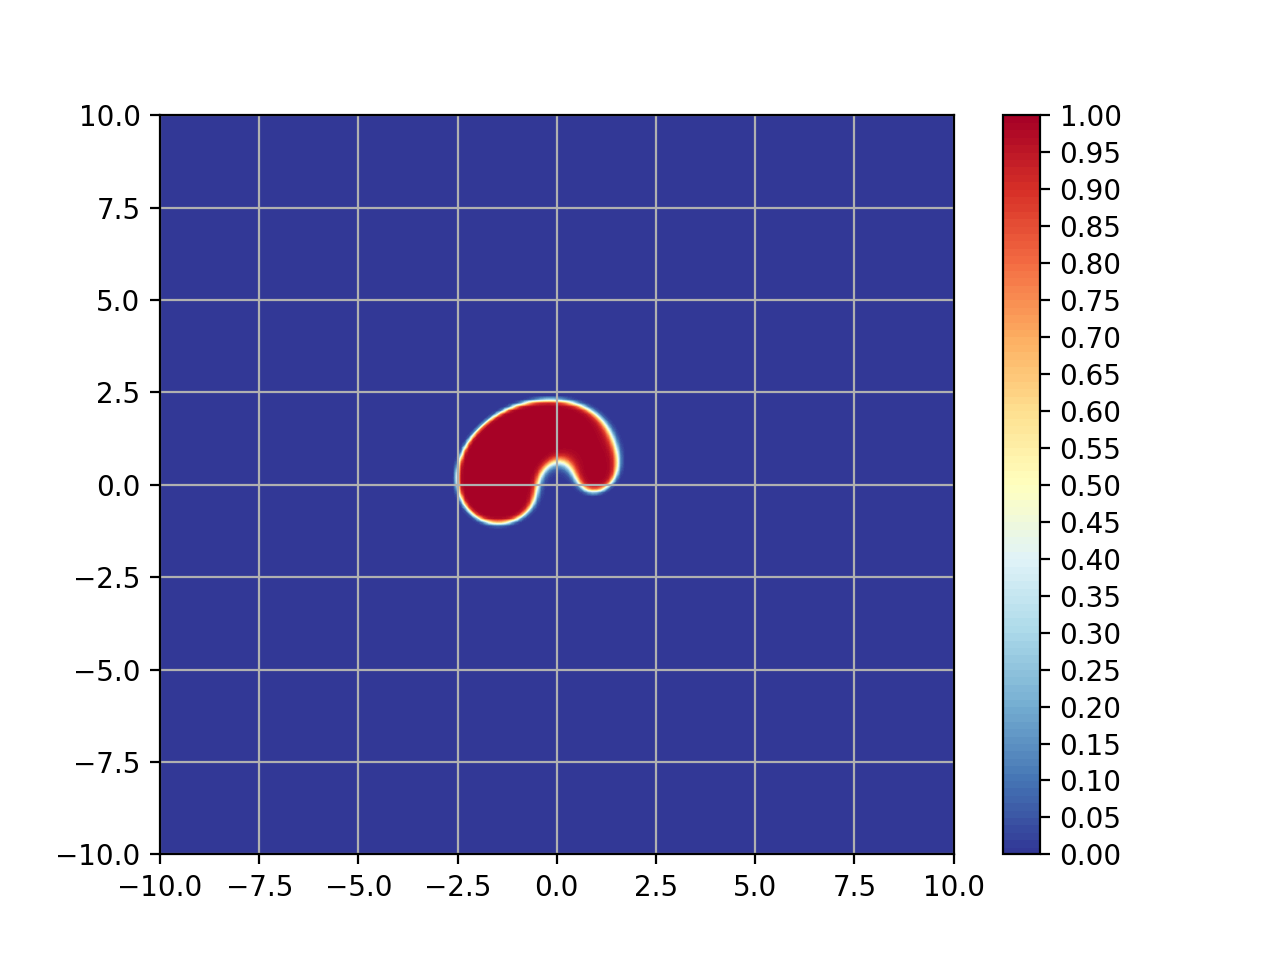

In [20]:
# plot the heatmap
levels = np.arange(-0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

plt.contourf(X1s, X2s, np.reshape(first_centers_heatmap_preds_softmax[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
plt.colorbar(ticks=ticks)

# # uncomment if you want to see the data and tighten the window
# plt.scatter(samples_x_1, samples_y_1, alpha=0.1, c='gray')
# plt.scatter(samples_x_2, samples_y_2, alpha=0.1, c='gray')
# plt.axis([-1.5,2.5, -1, 1.5])

plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


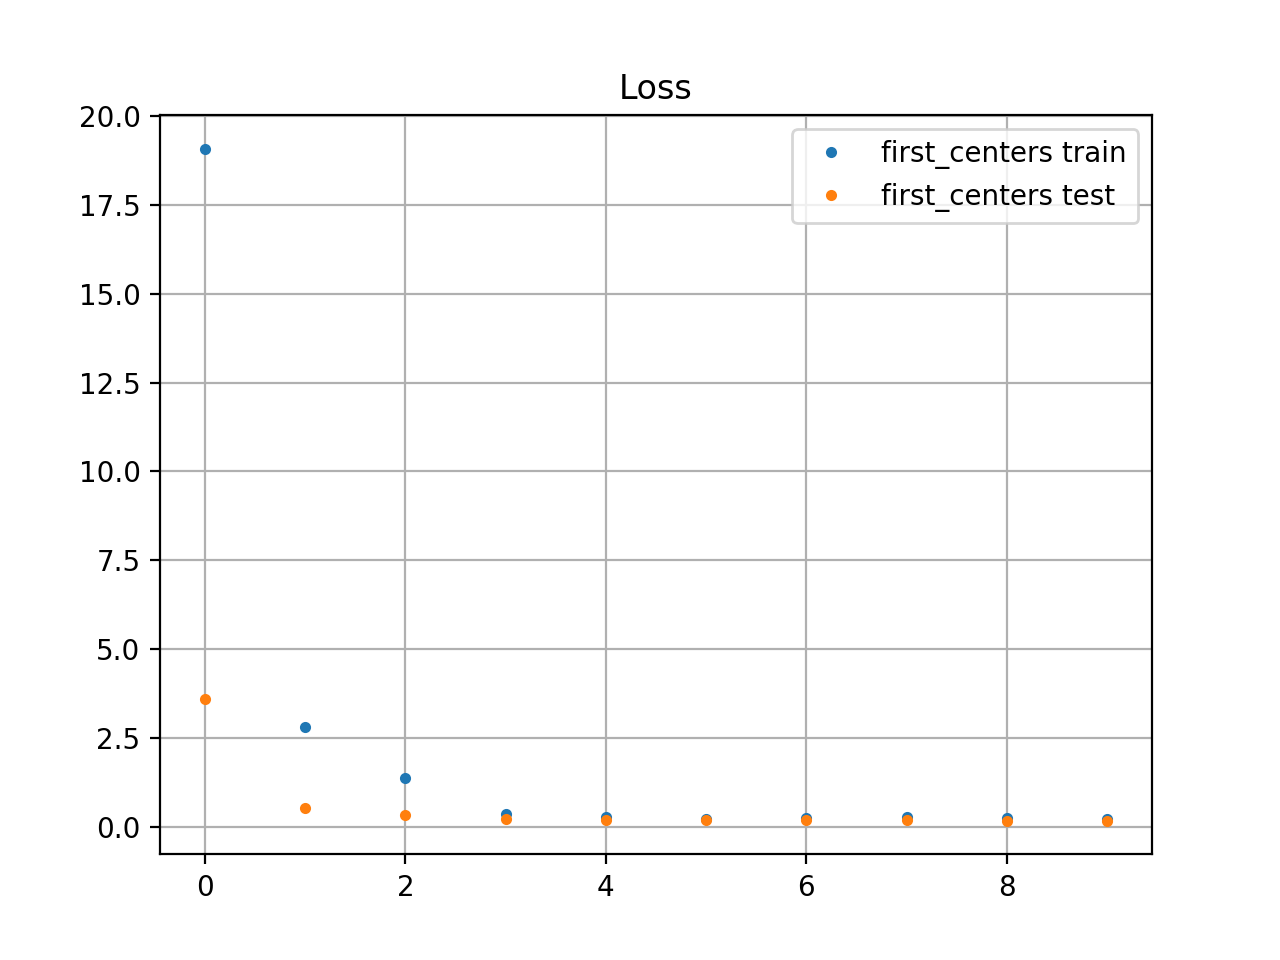

<IPython.core.display.Javascript object>


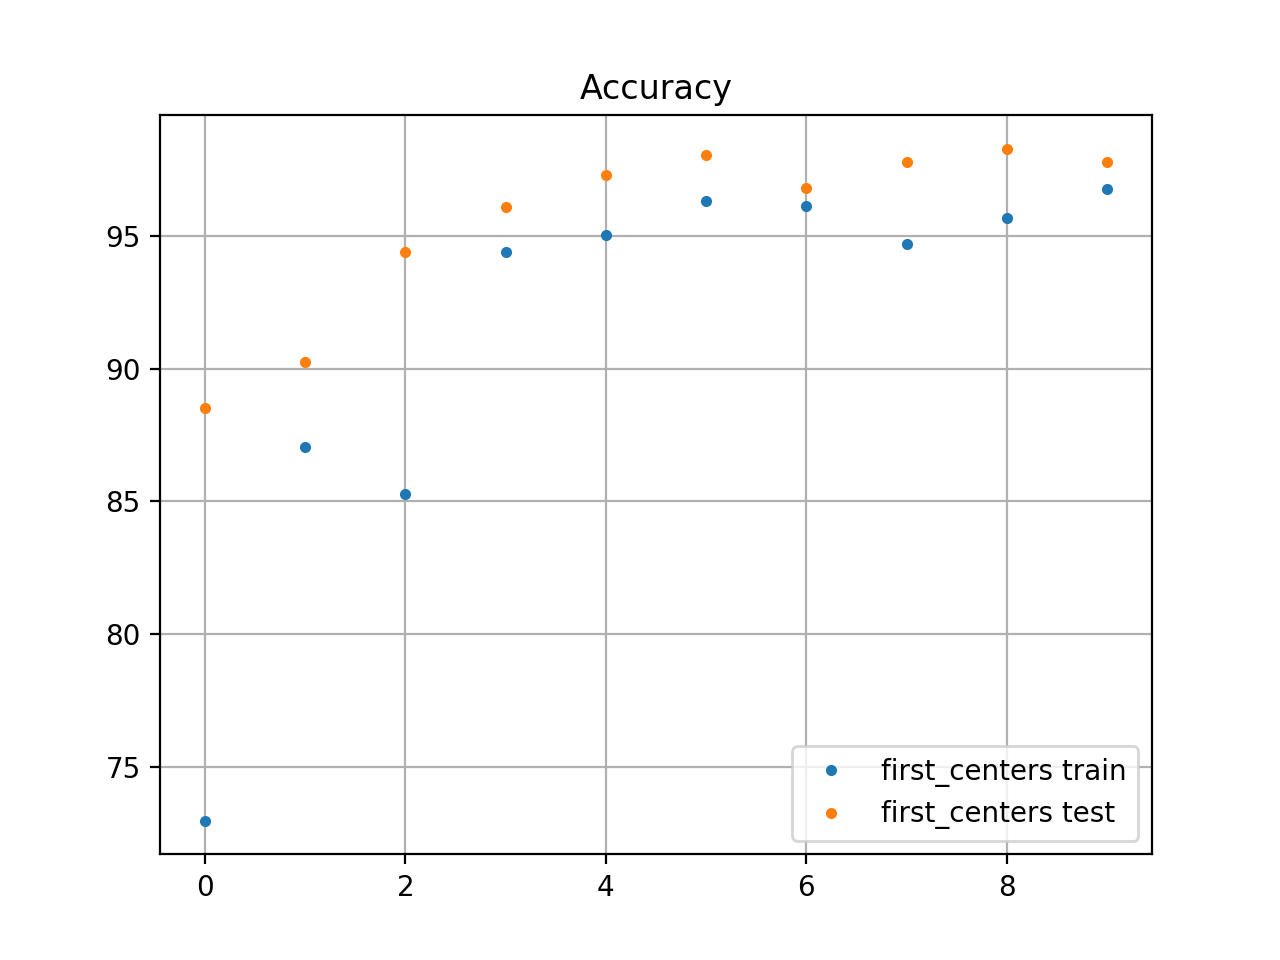

In [21]:
# acc and loss hist
plt.plot(first_centers_train_res['train_loss_hist'], marker='.', linestyle=' ', label='first_centers train')
plt.plot(first_centers_train_res['test_loss_hist'], marker='.', linestyle=' ', label='first_centers test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(first_centers_train_res['train_acc_hist'], marker='.', linestyle=' ', label='first_centers train')
plt.plot(first_centers_train_res['test_acc_hist'], marker='.', linestyle=' ', label='first_centers test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

In [22]:
### plot some FGN param movement during training

fl.centers
plotting neurons: [1 0]


<IPython.core.display.Javascript object>


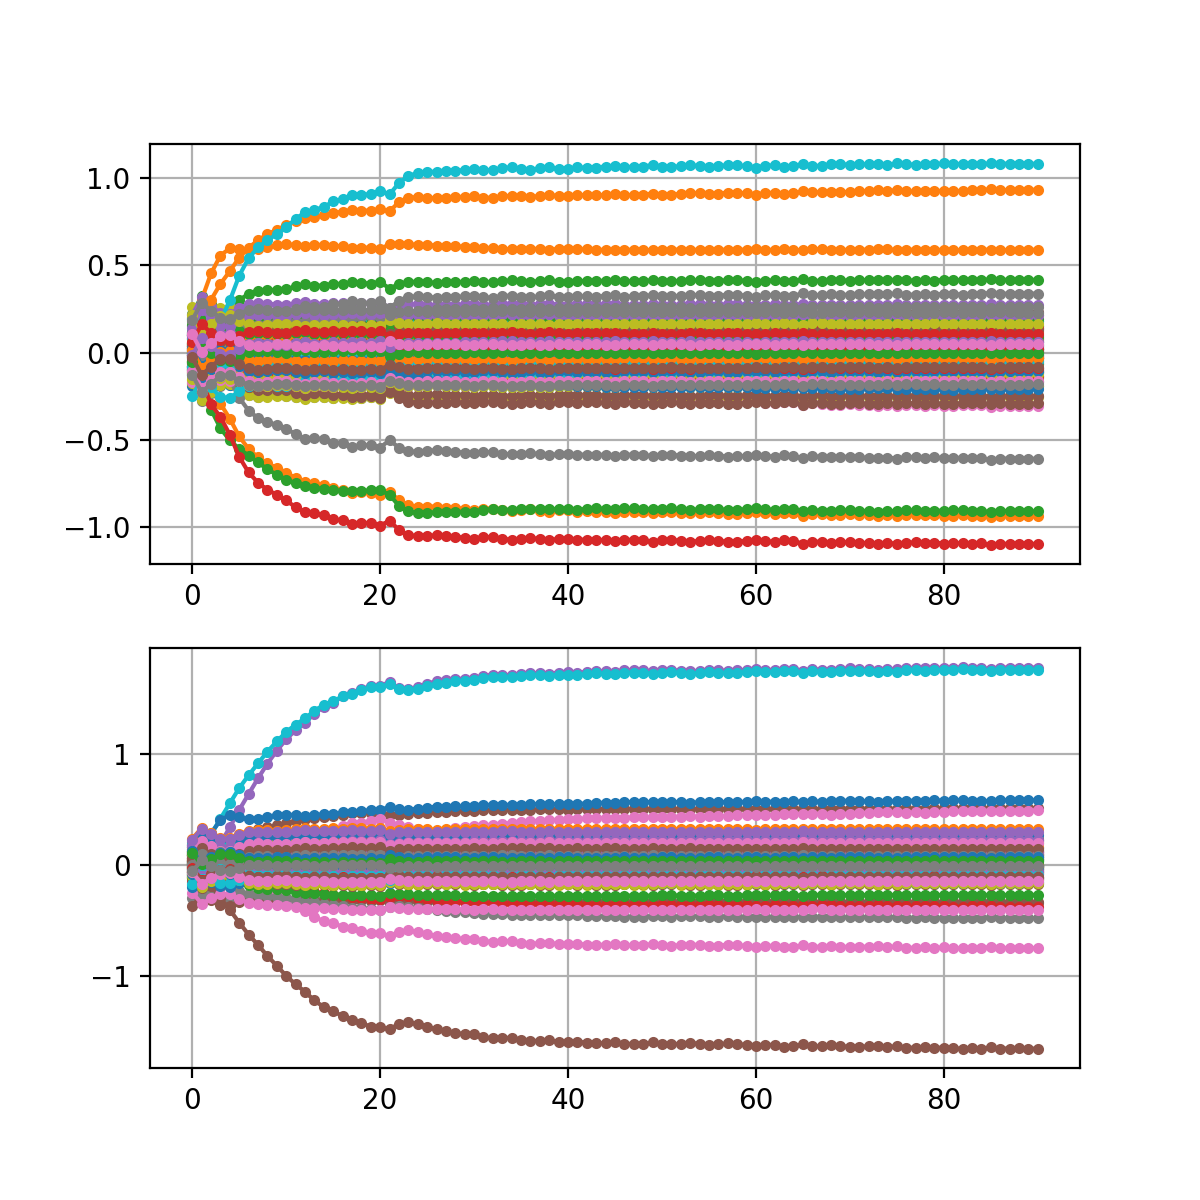

hidden_layers.0.centers
plotting neurons: [15 25]


<IPython.core.display.Javascript object>


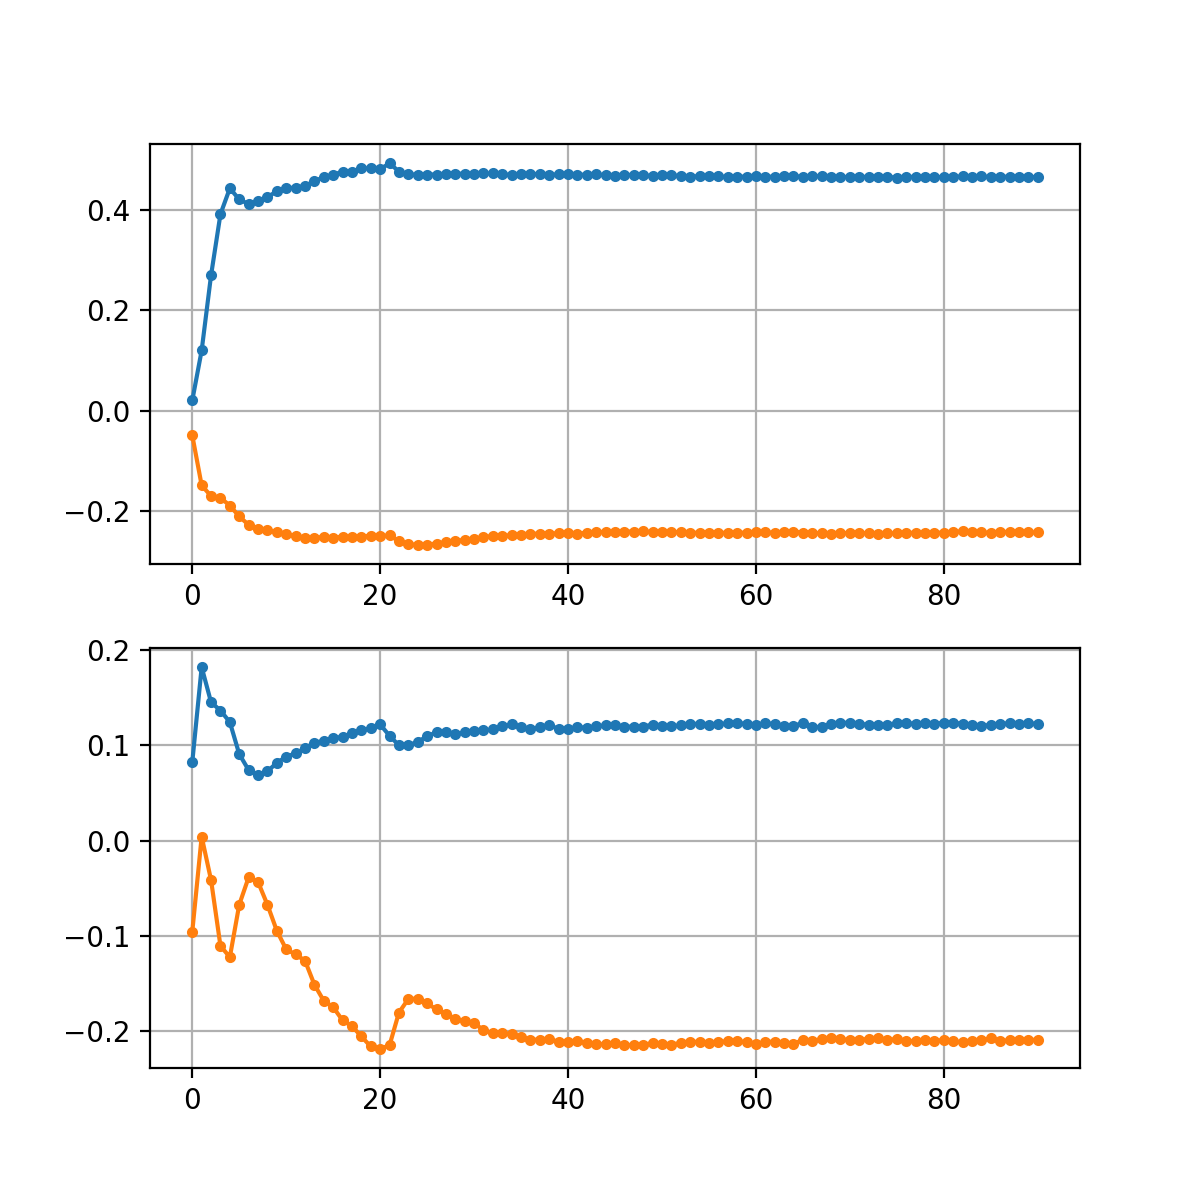

In [23]:
# plot centers history for only some hidden layer neuron

# which history to look at ?
train_res = first_centers_train_res

for k in train_res['histories'].keys():
    if 'centers' in k:
        print(k)
        plt.figure(figsize=(6,6))
        # print(np.shape(fgn_fgn_train_res['histories'][k]))
        # choose 4random neurons in the layer to print
        neurons =  np.random.choice(range(np.shape(train_res['histories'][k])[1]),2, replace=False)
        print("plotting neurons:", neurons)
        # plt.figure(figsize=(2,2))

        for idx,n in enumerate(neurons):
            x = train_res['histories'][k][:,n,:]
            # print(np.shape(x))
            plt.subplot(2,1,idx+1)
            plt.plot(x, marker='.', linestyle='-')
            # plt.axis([-3,3, -3, 3])
            plt.grid()
        plt.show()

fl.sigmas


<IPython.core.display.Javascript object>


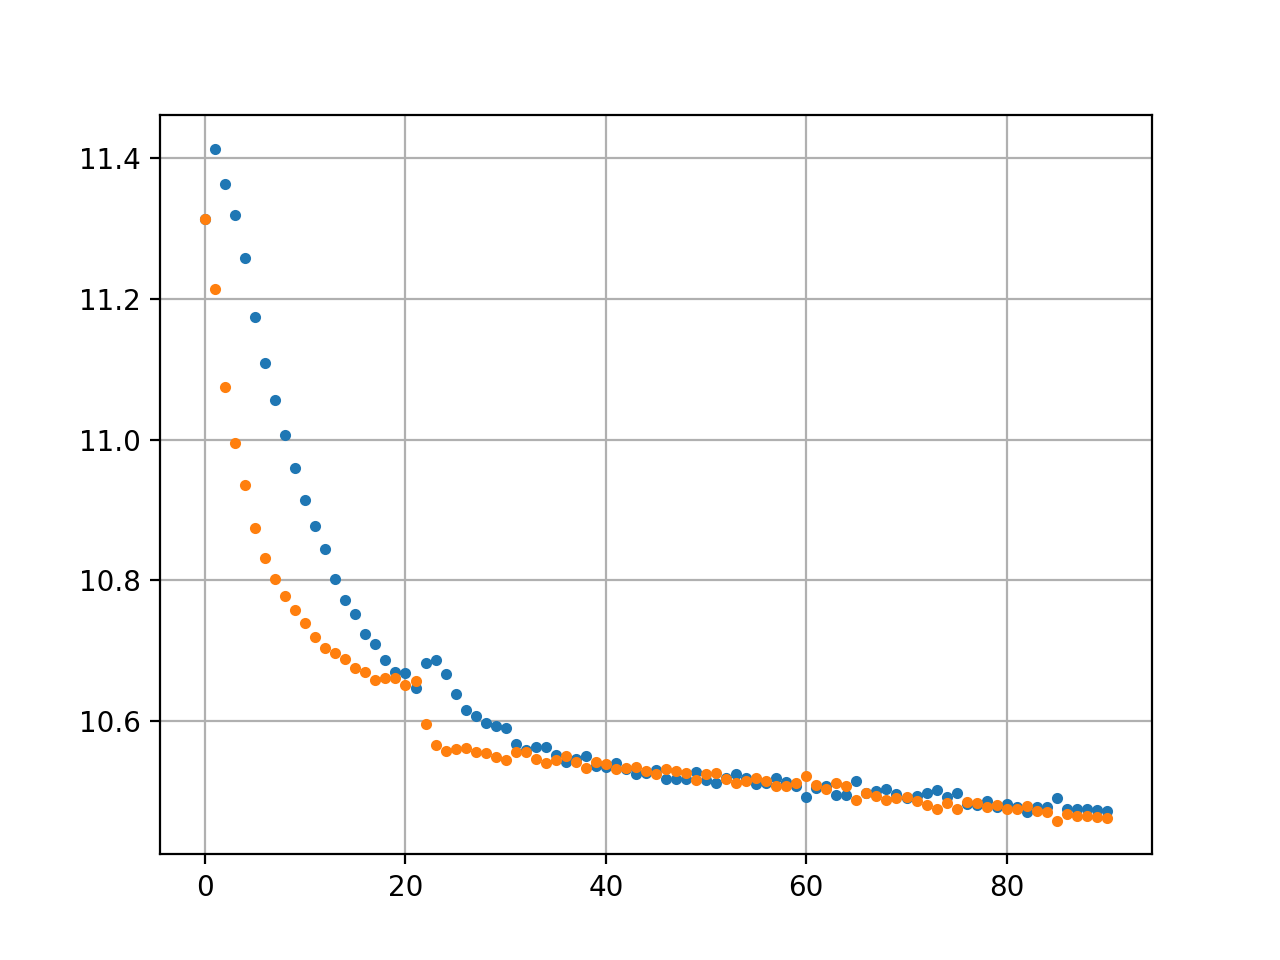

hidden_layers.0.sigmas


<IPython.core.display.Javascript object>


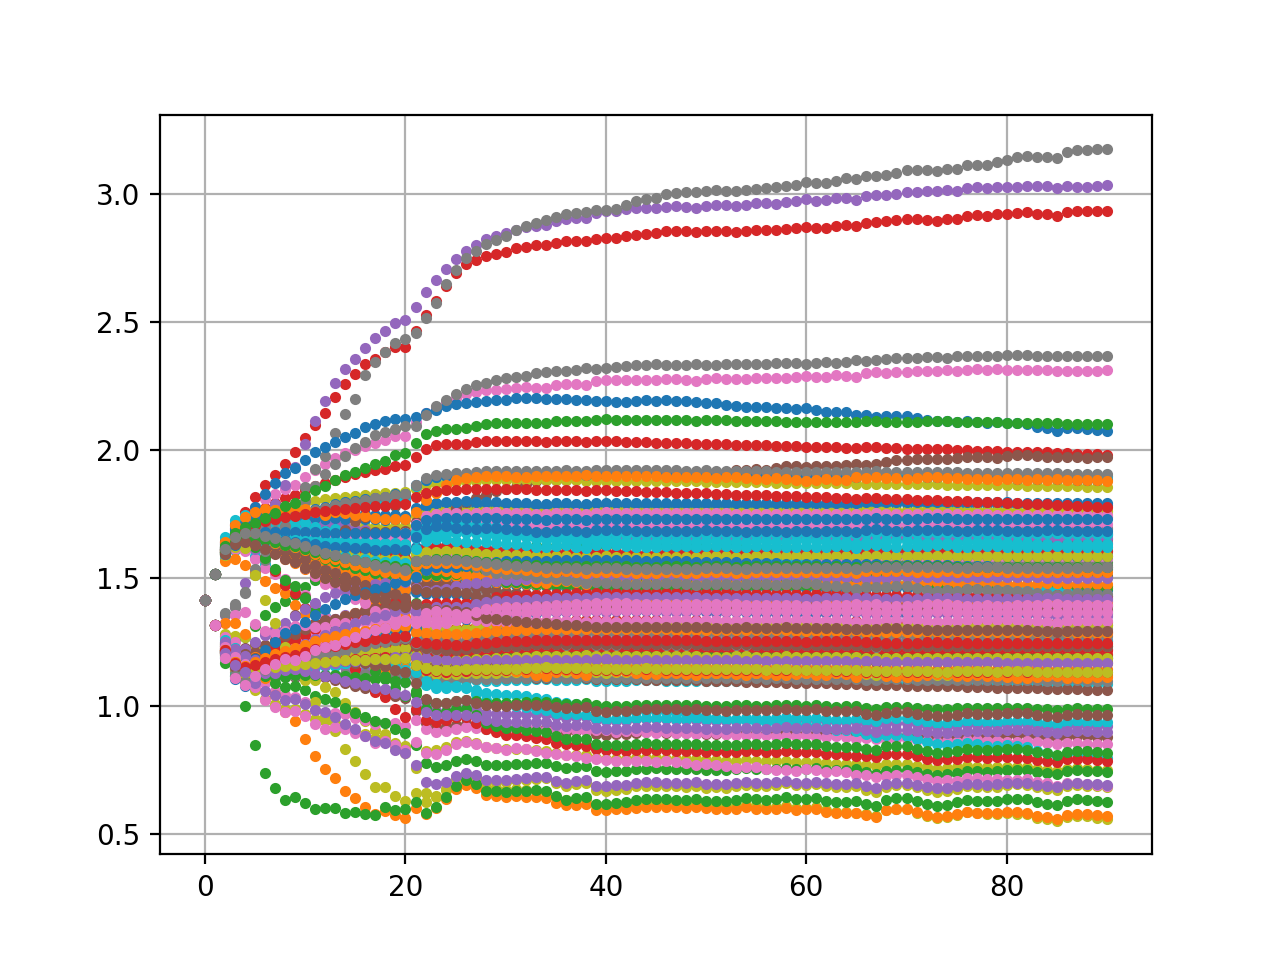

In [24]:
# check that sigma has shrunk
# plot sigma history
for k in train_res['histories'].keys():
    if 'sigmas' in k:
        print(k)
        for i in range(len(train_res['histories'][k][0])):
            plt.plot(train_res['histories'][k][:,i], marker='.', linestyle=' ')
        plt.grid()
        plt.show()